In [1]:
%matplotlib inline
import pandas as pd
import time
import sys
from pathlib import Path
from pprint import pprint
import numpy as np
from operator import add
from warnings import simplefilter
import datetime
from tqdm.notebook import tqdm

pd.options.mode.chained_assignment = None #comment if you want the warning message

In [2]:
def arffToDataframe(arff_file, normalize=False):
    from scipy.io import arff
    import pandas as pd
    data = arff.loadarff(arff_file)
    df = pd.DataFrame(data[0])
    df_int = bytesToInt(df)
    if normalize:
        df_int= normalizeDataframe(df_int, normalize)
    return df_int

def bytesToInt(df):
    import pandas as pd
    import numpy as np
    for column in df:
        df[column] = pd.to_numeric(df[column], errors='coerce').fillna(0).astype(np.int64)
    return df

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from operator import add
import warnings
import os
import sys
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import copy

#input file name
arff_file = "../mendeley.arff"

#name of the column defining the label
#label_name = 'CLASS_LABEL'

# These are the features used by the classifiers
features = pd.Index(["NumDots",
                     "SubdomainLevel",
                     "PathLevel",
                     "UrlLength",
                     "NumDash",
                     "NumDashInHostname",
                     "AtSymbol",
                     "TildeSymbol",
                     "NumUnderscore",
                     "NumPercent",
                     "NumQueryComponents",
                     "NumAmpersand",
                     "NumHash",
                     "NumNumericChars",
                     "NoHttps",
                     "RandomString",
                     "IpAddress",
                     "DomainInSubdomains",
                     "DomainInPaths",
                     "HttpsInHostname",
                     "HostnameLength",
                     "PathLength",
                     "QueryLength",
                     "DoubleSlashInPath",
                     "NumSensitiveWords",
                     "EmbeddedBrandName",
                     "PctExtHyperlinks",
                     "PctExtResourceUrls",
                     "ExtFavicon",
                     "InsecureForms",
                     "RelativeFormAction",
                     "ExtFormAction",
                     "AbnormalFormAction",
                     "PctNullSelfRedirectHyperlinks",
                     "FrequentDomainNameMismatch",
                     "FakeLinkInStatusBar",
                     "RightClickDisabled",
                     "PopUpWindow",
                     "SubmitInfoToEmail",
                     "IframeOrFrame",
                     "MissingTitle",
                     "ImagesOnlyInForm",
                     "SubdomainLevelRT",
                     "UrlLengthRT",
                     "PctExtResourceUrlsRT",
                     "AbnormalExtFormActionR",
                     "ExtMetaScriptLinkRT",
                     "PctExtNullSelfRedirectHyperlinksRT"
                    ])

In [4]:
print("Start Time: {}".format(datetime.datetime.now()))
begin_time = time.time()

Start Time: 2023-11-27 03:09:55.736817


In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score

# Laden Sie Ihren Datensatz als DataFrame 'df' hier
df = arffToDataframe(arff_file)

# Teilen Sie Ihren Datensatz in bösartige und gutartige Teile
#df_mal = df[df["CLASS_LABEL"] == 1]
#df_ben = df[df["CLASS_LABEL"] == 0]

trials_inner = 10
trials_outer = 10

# Repeat everything many times (this will ensure that also "test" will be changed)
for reps in tqdm(range(trials_outer)):
    
    # Teilen Sie Ihren Datensatz in bösartige und gutartige Teile
    df_mal = df[df["CLASS_LABEL"] == 1]
    df_ben = df[df["CLASS_LABEL"] == 0]
    
    # Extrahieren Sie den Testdatensatz
    test_mal = df_mal.sample(1000)
    test_ben = df_ben.sample(1000)
    test = pd.concat([test_mal, test_ben])

    # Entfernen Sie den Testdatensatz aus df_mal und df_ben
    df_mal = df_mal.drop(test_mal.index)
    df_ben = df_ben.drop(test_ben.index)

    # Extrahieren Sie den Trainingsdatensatz
    #train_sizes = [4000,6400, 8000]  # Eine Liste der gewünschten Trainingsgrößen
    train_sizes = [8000]  # Eine Liste der gewünschten Trainingsgrößen
    
    # Initialize the DataFrame to store the performance data
    performance_data = []
    
    # Repeat all the steps from 4 to 12 many times (accounting for different train_size)
    for train_size in train_sizes:
        print(f"Trainingsgröße: {train_size}")

        # Extrahieren Sie den Trainingsdatensatz
        #train_size = 1000
        train_mal = df_mal.sample(train_size // 2)
        train_ben = df_ben.sample(train_size // 2)
        train = pd.concat([train_mal, train_ben])

        # Hier sind die verschiedenen Anzahl von Iterationen, die wir ausprobieren wollen
        iterations_list = [2,4,16,32,64]
        #iterations_list = [64]

        performance = {}

        for iterations in tqdm(iterations_list):
            performance[iterations] = []
            performance[f"{iterations}_mean"] = []  # Hinzugefügt
            performance[f"{iterations}_std"] = []  # Hinzugefügt

            # Berechnen Sie die Anzahl der Samples, die in jeder Iteration beschriftet werden sollen
            labelling_amount = len(train) // iterations
            
            # Repeat all the steps from 5 to 12 many times (this means that the original "base_train" will change everytime, but "test" will be fixed
            for repetition in range(trials_inner):  # Ersetzen Sie 1 durch die gewünschte Anzahl von Wiederholungen
                base_training = train.sample(labelling_amount)
                unlabelled = train.drop(base_training.index)
                #print(len(base_training))
                #print(len(unlabelled))
                rf_base = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                                                min_weight_fraction_leaf=0.0, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                                bootstrap=True, oob_score=False, n_jobs=-1, random_state=0, 
                                                verbose=0, warm_start=False, class_weight=None)
                #rf_base = RandomForestClassifier()
                rf_base.fit(base_training[features], base_training["CLASS_LABEL"])

                # Iteration 1
                test_preds = rf_base.predict(test[features])
                f1_score_initial = f1_score(test["CLASS_LABEL"], test_preds)
                accuracy_initial = accuracy_score(test["CLASS_LABEL"], test_preds)
                cm_initial = confusion_matrix(test["CLASS_LABEL"], test_preds)
                
                precision_initial = precision_score(test["CLASS_LABEL"], test_preds)
                recall_initial = recall_score(test["CLASS_LABEL"], test_preds)
                
                false_positives_initial = cm_initial[0][1]
                false_negatives_initial = cm_initial[1][0]
                #print(recall_initial)
                #performance[iterations].append((f1_score_initial, accuracy_initial, false_positives_initial, false_negatives_initial))
                performance[iterations].append((f1_score_initial, accuracy_initial, precision_initial, recall_initial, false_positives_initial, false_negatives_initial,len(base_training)))

                # Iterationen 1+
                for i in range(1, iterations):
                    # Ermitteln Sie die Konfidenz für jedes unbeschriftete Sample
                    pred_proba = rf_base.predict_proba(unlabelled[features])

                    #print(least_confident_indices)
                    malicious_confidences = []
                    benign_confidences = []

                    try:
                        for idx, prob in enumerate(pred_proba[:, 1]):  # Hier ändern wir pred_proba in pred_proba[:, 1]
                            if prob != 1 and prob != 0:
                                confidence = abs(0.5 - prob)
                                if prob >= 0.5:
                                    malicious_confidences.append((idx, confidence))
                                else:
                                    benign_confidences.append((idx, confidence))
                            if prob == 1:
                                confidence = 1
                                malicious_confidences.append((idx, confidence))
                            if prob == 0:
                                confidence = 1
                                benign_confidences.append((idx, confidence))
                    except IndexError:
                        print(f"Alle Konfidenzen sind entweder 1 oder 0 in Iteration {i}. Überspringe diese Iteration.")
                        continue
                        
                                
                    #print(len(base_training))
                    # Sort the confidences
                    malicious_confidences = sorted(malicious_confidences, key=lambda x: x[1])
                    benign_confidences = sorted(benign_confidences, key=lambda x: x[1])
                    #print(len(malicious_confidences))
                    #print(len(benign_confidences))

                    # Combine the confidences
                    all_confidences = malicious_confidences + benign_confidences
                    all_confidences = sorted(all_confidences, key=lambda x: x[1])
                    #print(all_confidences)

                    # Get the indices of the samples with the lowest confidence
                    least_confident_indices = [index for index, confidence in all_confidences[:labelling_amount]]
                    #print(len(least_confident_indices))


                    # Beschriften Sie die am wenigsten sicher klassifizierten Samples
                    new_labelled_data = unlabelled.iloc[least_confident_indices]
                    #print(new_labelled_data)

                    # Füge die neu beschrifteten Daten zum Trainingsset hinzu
                    base_training = pd.concat([base_training, new_labelled_data])
                    #print(len(unlabelled))
                    #print(len(base_training))
                    
                    # Entferne die neu beschrifteten Daten aus dem unbeschrifteten Datensatz
                    unlabelled = unlabelled.drop(new_labelled_data.index)
                    #print(len(unlabelled))

                    # Trainiere den RandomForestClassifier mit den neuen Daten (Compare results with bootstrap = False vs True)
                    rf_base = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                                                min_weight_fraction_leaf=0.0, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                                bootstrap=True, oob_score=False, n_jobs=-1, random_state=0, 
                                                verbose=0, warm_start=False, class_weight=None)
                    #rf_base = RandomForestClassifier()
                    rf_base.fit(base_training[features], base_training["CLASS_LABEL"])

                    # Teste den Classifier und berechne den F1-Score
                    test_preds = rf_base.predict(test[features])
                    f1_score_initial = f1_score(test["CLASS_LABEL"], test_preds)
                    accuracy_initial = accuracy_score(test["CLASS_LABEL"], test_preds)
                    cm_initial = confusion_matrix(test["CLASS_LABEL"], test_preds)
                    precision_initial = precision_score(test["CLASS_LABEL"], test_preds)
                    recall_initial = recall_score(test["CLASS_LABEL"], test_preds)
                    false_positives_initial = cm_initial[0][1]
                    false_negatives_initial = cm_initial[1][0]
                    
                    #precision_initial = precision_score(test["CLASS_LABEL"], test_preds)
                    #recall_initial = recall_score(test["CLASS_LABEL"], test_preds)
                    #print(accuracy_initial)
                    #performance[iterations].append((f1_score_initial, accuracy_initial, false_positives_initial, false_negatives_initial))
                    performance[iterations].append((f1_score_initial, accuracy_initial, precision_initial, recall_initial, false_positives_initial, false_negatives_initial,len(base_training)))
                    #print(performance[iterations])

        # Ergebnisse ausgeben
        #print()
        #print("Ergebnisse:")

        for iter_count, scores in performance.items():
            if iter_count in iterations_list:
                f1_scores = [score[0] for score in scores]
                accuracy_scores = [score[1] for score in scores]
                mean_scores = (np.mean(f1_scores), np.mean(accuracy_scores))
                std_scores = (np.std(f1_scores), np.std(accuracy_scores))
                performance[f"{iter_count}_mean"] = mean_scores
                performance[f"{iter_count}_std"] = std_scores

        #print(performance)
        #print()
        
        for iter_count, scores in performance.items():
            if isinstance(iter_count, int):
                for score in scores:
                    performance_data.append({
                        "reps": reps,  # Add the repetition index
                        "train_size": train_size,
                        "iterations": iter_count,
                        "f1_score": score[0],
                        "accuracy": score[1],
                        "precision": score[2],  # Add precision
                        "recall": score[3],  # Add recall
                        #"false_positives": score[4],
                        #"false_negatives": score[5],
                        "training_size": score[6],
                    })
                    
        '''for iter_count, scores in performance.items():
            if isinstance(iter_count, int):
                #f1_scores = [score[0] for score in scores]
                accuracy_scores = [score[1] for score in scores]
                #print(f"Iterationen: {iter_count}")
                #print(f"  Durchschnittlicher F1-Score: {performance[f'{iter_count}_mean'][0]:.4f}")
                #print(f"  Standardabweichung F1-Score: {performance[f'{iter_count}_std'][0]:.4f}")
                #print(f"  Durchschnittliche Genauigkeit: {performance[f'{iter_count}_mean'][1]:.4f}")
                #print(f"  Standardabweichung Genauigkeit: {performance[f'{iter_count}_std'][1]:.4f}")
                # Letzter F1-Score und letzte Genauigkeit für jede Iteration
                #print(f"  Letzter F1-Score: {f1_scores[-1]:.4f}")
                #print(f"  Letzte Genauigkeit: {accuracy_scores[-1]:.4f}")
                #print()'''
                

# Convert the performance_data list to a DataFrame
performance_df = pd.DataFrame(performance_data)

# Filter the performance_df to keep only the columns needed for the plot
filtered_performance_df = performance_df[["train_size", "iterations", "accuracy", "reps","f1_score", "precision", "recall"]]
#filtered_performance_df = performance_df[["reps", "train_size", "iterations", "f1_score", "accuracy", "precision", "recall"]]


  0%|          | 0/10 [00:00<?, ?it/s]

Trainingsgröße: 8000


  0%|          | 0/5 [00:00<?, ?it/s]

Trainingsgröße: 8000


  0%|          | 0/5 [00:00<?, ?it/s]

Trainingsgröße: 8000


  0%|          | 0/5 [00:00<?, ?it/s]

Trainingsgröße: 8000


  0%|          | 0/5 [00:00<?, ?it/s]

Trainingsgröße: 8000


  0%|          | 0/5 [00:00<?, ?it/s]

Trainingsgröße: 8000


  0%|          | 0/5 [00:00<?, ?it/s]

Trainingsgröße: 8000


  0%|          | 0/5 [00:00<?, ?it/s]

Trainingsgröße: 8000


  0%|          | 0/5 [00:00<?, ?it/s]

Trainingsgröße: 8000


  0%|          | 0/5 [00:00<?, ?it/s]

Trainingsgröße: 8000


  0%|          | 0/5 [00:00<?, ?it/s]

In [6]:
print("End Time: {}".format(datetime.datetime.now()))

end_time = time.time()

total_time = end_time - begin_time

print("Runtime: {}s".format(total_time))

End Time: 2023-11-27 04:00:54.927085
Runtime: 3059.190267801285s


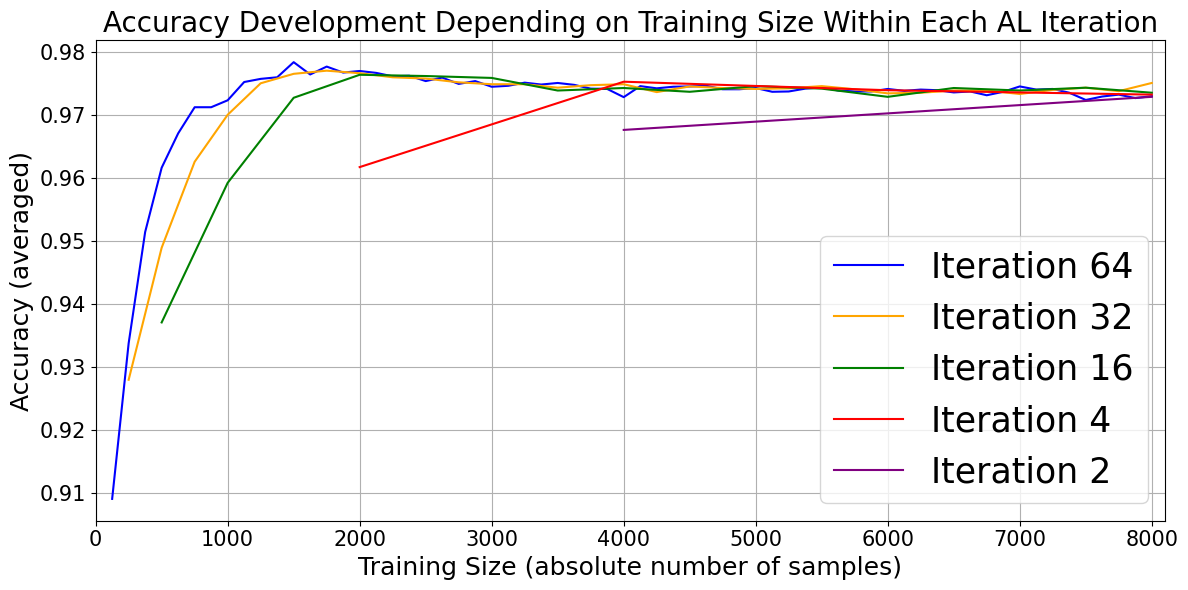

In [15]:
#Accuracy
import matplotlib.pyplot as plt

# Prepare a distinct color for each iteration
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
max_training_size = max(train_sizes)

plt.figure(figsize=(12, 6))


# Group by 'training_size' and 'iterations', then calculate mean accuracy
grouped_df = performance_df.groupby(['training_size', 'iterations'])['accuracy'].mean().reset_index()

# Iterate over unique iterations in the grouped DataFrame
for i, iteration in enumerate(grouped_df['iterations'].unique()):
    iteration_df = grouped_df[grouped_df['iterations'] == iteration]
    
    # Sort values by training size for coherent line plots
    iteration_df = iteration_df.sort_values(by='training_size')

    plt.plot(iteration_df['training_size'], iteration_df['accuracy'], label=f"Iteration {iteration}", color=colors[i % len(colors)])

plt.title('Accuracy Development Depending on Training Size Within Each AL Iteration', fontsize=20)
plt.xlabel('Training Size (absolute number of samples)', fontsize=18)
plt.ylabel('Accuracy (averaged)', fontsize=18)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlim(0, max_training_size+100)  # Set the maximum value for the x-axis
plt.legend(loc='lower right', fontsize=25)
plt.grid(True)

plt.tight_layout()
plt.savefig("../figures/exp3/exp3_acc-8000.pdf")



plt.show()


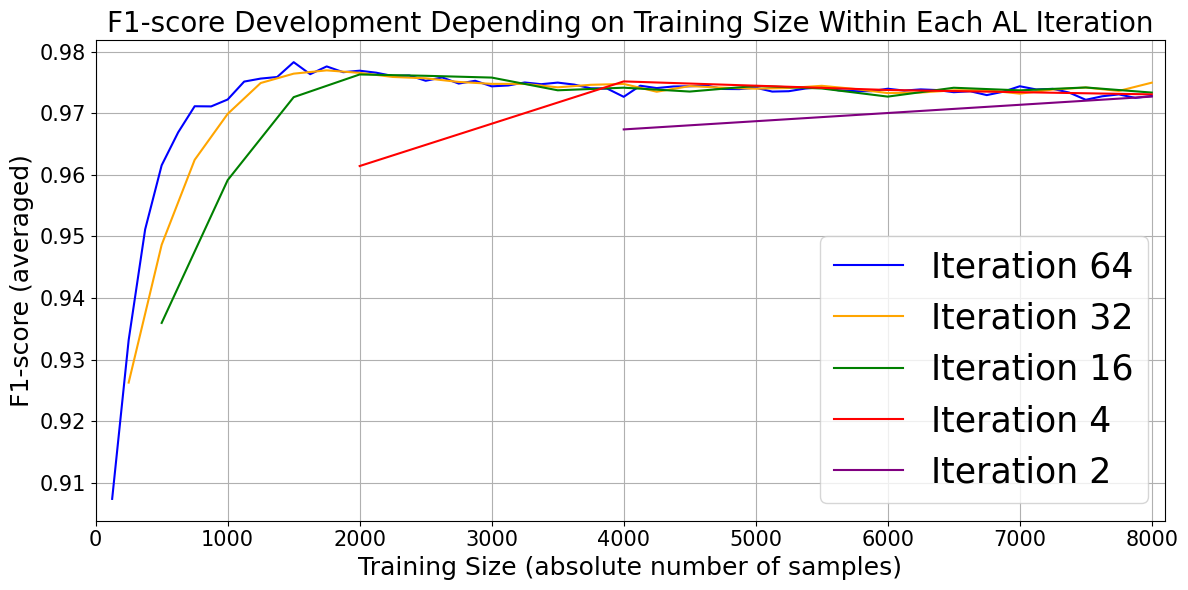

In [16]:
#F1
import matplotlib.pyplot as plt

# Prepare a distinct color for each iteration
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
max_training_size = max(train_sizes)

plt.figure(figsize=(12, 6))


# Group by 'training_size' and 'iterations', then calculate mean accuracy
grouped_df = performance_df.groupby(['training_size', 'iterations'])['f1_score'].mean().reset_index()

# Iterate over unique iterations in the grouped DataFrame
for i, iteration in enumerate(grouped_df['iterations'].unique()):
    iteration_df = grouped_df[grouped_df['iterations'] == iteration]
    
    # Sort values by training size for coherent line plots
    iteration_df = iteration_df.sort_values(by='training_size')

    plt.plot(iteration_df['training_size'], iteration_df['f1_score'], label=f"Iteration {iteration}", color=colors[i % len(colors)])

plt.title('F1-score Development Depending on Training Size Within Each AL Iteration', fontsize=20)
plt.xlabel('Training Size (absolute number of samples)', fontsize=18)
plt.ylabel('F1-score (averaged)', fontsize=18)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlim(0, max_training_size+100)  # Set the maximum value for the x-axis
plt.legend(loc='lower right', fontsize=25)
plt.grid(True)

plt.tight_layout()
plt.savefig("../figures/exp3/exp3_f1-8000.pdf")

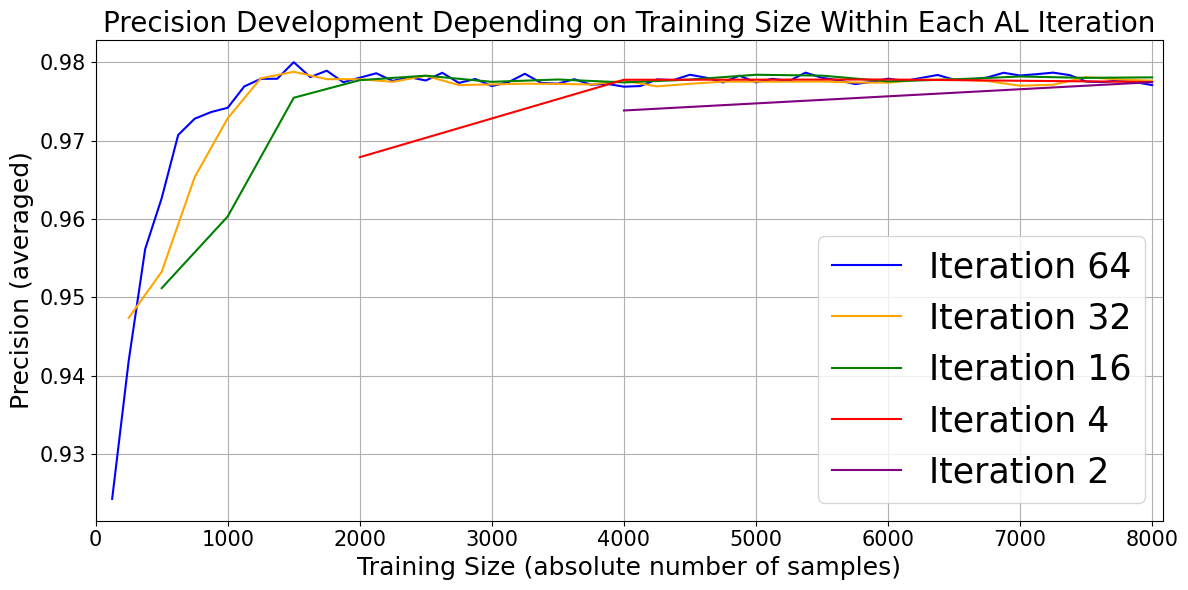

In [19]:
#Precision
import matplotlib.pyplot as plt

# Prepare a distinct color for each iteration
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
max_training_size = max(train_sizes)

plt.figure(figsize=(12, 6))


# Group by 'training_size' and 'iterations', then calculate mean accuracy
grouped_df = performance_df.groupby(['training_size', 'iterations'])['precision'].mean().reset_index()

# Iterate over unique iterations in the grouped DataFrame
for i, iteration in enumerate(grouped_df['iterations'].unique()):
    iteration_df = grouped_df[grouped_df['iterations'] == iteration]
    
    # Sort values by training size for coherent line plots
    iteration_df = iteration_df.sort_values(by='training_size')

    plt.plot(iteration_df['training_size'], iteration_df['precision'], label=f"Iteration {iteration}", color=colors[i % len(colors)])

plt.title('Precision Development Depending on Training Size Within Each AL Iteration', fontsize=20)
plt.xlabel('Training Size (absolute number of samples)', fontsize=18)
plt.ylabel('Precision (averaged)', fontsize=18)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlim(0, max_training_size+(max_training_size*0.01))  # Set the maximum value for the x-axis
plt.legend(loc='lower right', fontsize=25)
plt.grid(True)

plt.tight_layout()
plt.savefig("../figures/exp3/exp3_precision-8000.pdf")

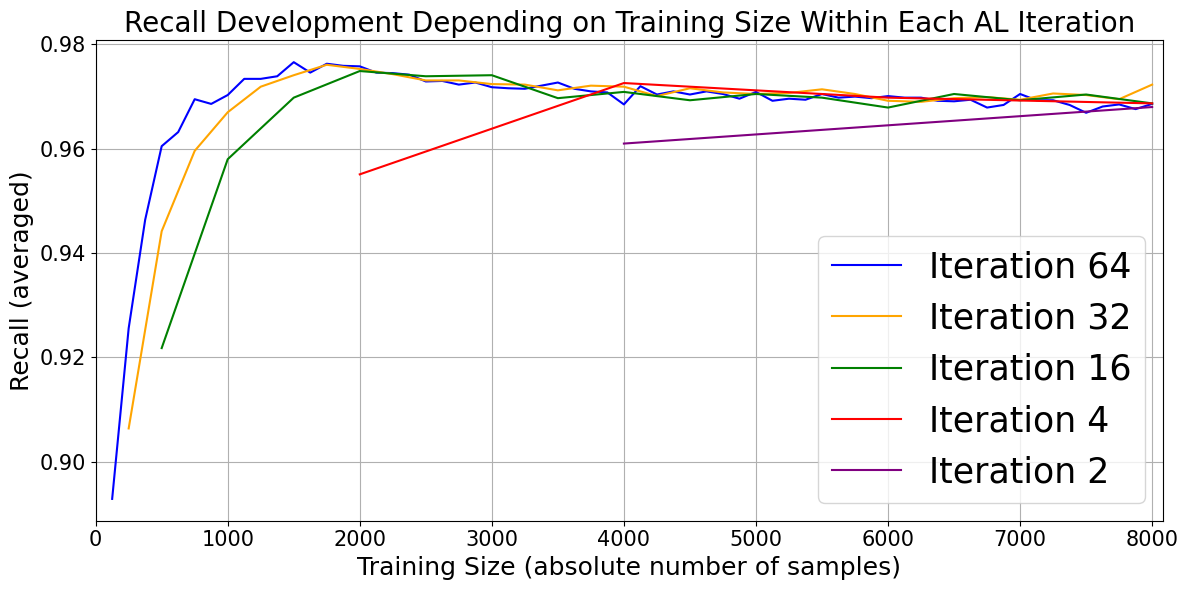

In [20]:
#Recall
import matplotlib.pyplot as plt

# Prepare a distinct color for each iteration
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
max_training_size = max(train_sizes)

plt.figure(figsize=(12, 6))


# Group by 'training_size' and 'iterations', then calculate mean accuracy
grouped_df = performance_df.groupby(['training_size', 'iterations'])['recall'].mean().reset_index()

# Iterate over unique iterations in the grouped DataFrame
for i, iteration in enumerate(grouped_df['iterations'].unique()):
    iteration_df = grouped_df[grouped_df['iterations'] == iteration]
    
    # Sort values by training size for coherent line plots
    iteration_df = iteration_df.sort_values(by='training_size')

    plt.plot(iteration_df['training_size'], iteration_df['recall'], label=f"Iteration {iteration}", color=colors[i % len(colors)])

plt.title('Recall Development Depending on Training Size Within Each AL Iteration', fontsize=20)
plt.xlabel('Training Size (absolute number of samples)', fontsize=18)
plt.ylabel('Recall (averaged)', fontsize=18)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlim(0, max_training_size+(max_training_size*0.01))  # Set the maximum value for the x-axis
plt.legend(loc='lower right', fontsize=25)
plt.grid(True)

plt.tight_layout()
plt.savefig("../figures/exp3/exp3_recall-8000.pdf")

In [11]:
#### SAVING RESULTS

import pickle
results_folder = "../results/exp3/"

## Results
with open(results_folder + 'performance_df-8000.pkl', 'wb') as f:
    pickle.dump(performance_df, f)